In [2]:
# get all imports out of the way
import tensorneat as tn
import jax.numpy as jnp
import pandas as pd

In [3]:
# get all the symbols we can pull live data for
import os

# Path to the directory
directory_path = "hist_data/stocks/single"

# List all files in the directory
files = os.listdir(directory_path)

live_syms = [file.split('_')[0] for file in files]

# drop nans split by symbol and join on date
file_path = "hist_data/stocks/sp500_stocks.csv"  # Update this path if needed
df = pd.read_csv(file_path)

df = df.dropna()

symbols = df['Symbol'].unique()
symbol_dfs = {symbol: df[df['Symbol'] == symbol] for symbol in symbols}

merged_df = symbol_dfs[symbols[0]].set_index('Date')

for symbol in symbols[1:]:
    symbol_data = symbol_dfs[symbol].set_index('Date')
    if (len(symbol_data) == 3768 and symbol in live_syms):
        merged_df = merged_df.join(symbol_data, how='inner', rsuffix=f"_{symbol}")

tensorneat_input = merged_df.to_numpy()

print(tensorneat_input.shape)

(3768, 1029)


In [4]:
print(merged_df.head())

           Symbol  Adj Close     Close      High       Low      Open  \
Date                                                                   
2010-01-04    AOS   5.937266  7.435000  7.480000  7.261667  7.295000   
2010-01-05    AOS   5.861404  7.340000  7.431667  7.308333  7.431667   
2010-01-06    AOS   5.864068  7.343333  7.405000  7.301667  7.335000   
2010-01-07    AOS   5.881369  7.365000  7.425000  7.311667  7.356667   
2010-01-08    AOS   5.967879  7.473333  7.485000  7.311667  7.331667   

               Volume Symbol_ABT  Adj Close_ABT  Close_ABT  ...    Low_WMB  \
Date                                                        ...              
2010-01-04  1104600.0        ABT      18.763718  26.129908  ...  17.445280   
2010-01-05  1207200.0        ABT      18.612118  25.918797  ...  17.534952   
2010-01-06   663000.0        ABT      18.715481  26.062737  ...  17.771360   
2010-01-07   564000.0        ABT      18.870522  26.278646  ...  18.072985   
2010-01-08   504600.0      

In [5]:
# create a target array

close_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(3766, 147)
(3768, 147)


In [6]:
import jax.numpy as jnp
train_test_split = 0.9

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")


Sample Count: 3766
Train Size: 3389
Shape of INPUTS: (3389, 147)
Shape of RETURNS: (3389, 147)


In [7]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblem(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
      
      # Find the index of the maximum output for each day
      selected_indices = jnp.argmax(actions, axis=1)
      
      # Calculate the reward based on the selected index
      reward = jnp.take_along_axis(RETURNS, selected_indices[:, None], axis=1).squeeze()
      
      # Return the mean reward
      return jnp.mean(reward)

  def show(self, state, randkey, act_func, params, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      selected_indices = jnp.argmax(actions, axis=1)

      # Move data to host numpy
      from jax import device_get
      import numpy as np
      selected_indices_np = np.asarray(device_get(selected_indices)).ravel()
      returns_np = np.asarray(device_get(TEST_RETURNS))

      # Ensure indices are within bounds
      num_columns = returns_np.shape[1]
      selected_indices_np = np.clip(selected_indices_np, 0, num_columns - 1)

      # Calculate performance based on selected indices
      perf = 100.0
      perf_hist = []
      last_pick = live_syms[selected_indices_np[-1]]
      print("Last selected symbol:", last_pick)
      for i in range(len(selected_indices_np)-1):
          selected_return = returns_np[i, selected_indices_np[i]]
          perf += perf * float(selected_return)
          perf_hist.append(float(perf))

      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblem()



In [ ]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
from utils.neat_trading_problem import TradingProblemBase
EPISODE_LEN = 34

class TradingProblemTopK(TradingProblemBase):
  jitable = True
  
  def __init__(
      self,
      epoch_len,
      pop_size,
      k=3
  ):
    super().__init__()
    self.epoch_len = epoch_len
    self.pop_size = pop_size
    self.k = k

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)
  
  @property
  def input_data_len(self):
     return INPUTS.shape[0]

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params, epoch_start):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS[epoch_start:epoch_start+self.epoch_len])

      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, self.k)

      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)

      # Gather the rewards for the top-k indices
      rewards = jnp.take_along_axis(RETURNS, topk_indices, axis=1)

      # Calculate the weighted reward
      weighted_rewards = jnp.sum(rewards, axis=1) / self.k
      return jnp.mean(weighted_rewards)

  def show(self, state, randkey, act_func, params, k=3, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Move data to host numpy
      from jax import device_get
      import numpy as np
      topk_indices_np = np.asarray(device_get(topk_indices))
      softmax_weights_np = np.asarray(device_get(topk_values))
      returns_np = np.asarray(device_get(TEST_RETURNS))
      
      # Calculate performance based on top-k weighted rewards
      perf = 100.0
      perf_hist = []
      todays_syms = [live_syms[i] for i in topk_indices_np[-1]]
      print("Today's selected symbols:", todays_syms)
      for i in range(len(topk_indices_np)-2):
          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[i]]
          
          # Calculate the weighted reward
          weighted_reward = np.mean(rewards)
          if ((len(topk_indices_np) - i) < 20):
             current_syms = [live_syms[idx] for idx in topk_indices_np[i]]
             print(current_syms)
             print(rewards)
          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))
      
      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

  def show_averaged(self, state, randkey, act_func, params_list, k=3, *args, **kwargs):
      """
      Show the averaged performance of multiple networks.
      
      Args:
          state: The state of the problem.
          randkey: Random key for JAX operations.
          act_func: Activation function for the networks.
          params_list: List of network parameters (one for each network).
          k: Number of top-k actions to consider.
      """
      import numpy as np
      from jax import device_get
      import matplotlib.pyplot as plt

      # Initialize performance tracking
      perf = 100.0
      perf_hist = []

      # Iterate over the test inputs
      for i in range(TEST_INPUTS.shape[0]):
          # Collect actions from all networks
          actions_list = [
              jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS[i:i+1, :])
              for params in params_list
          ]

          # Average the actions across all networks
          avg_actions = jnp.mean(jnp.stack(actions_list, axis=0), axis=0)

          # Get the top-k values and indices
          topk_values, topk_indices = jax.lax.top_k(avg_actions, k)

          # Apply softmax to the top-k values to get weights
          softmax_weights = jax.nn.softmax(topk_values, axis=1)

          # Move data to host numpy
          topk_indices_np = np.asarray(device_get(topk_indices))
          softmax_weights_np = np.asarray(device_get(softmax_weights))
          returns_np = np.asarray(device_get(TEST_RETURNS))

          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[0]]
          weighted_reward = np.sum(softmax_weights_np[0] * rewards)

          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))

      # Plot the performance history
      plt.plot(perf_hist[:-5])
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblemTopK(epoch_len=377, pop_size=144)



In [9]:
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import DefaultGenome, BiasNode, DefaultConn, DefaultMutation
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm
from utils.neat_trading_pipeline import TradingPipeline

# Construct the pipeline and run
pipeline = TradingPipeline(
    algorithm=NEAT(
        pop_size=144,
        species_size=7,
        survival_threshold=0.1,
        compatibility_threshold=0.8,
        genome=DefaultGenome(
            max_nodes=500,
            max_conns=1500,
            num_inputs=features.shape[1],
            num_outputs=target.shape[1],
            init_hidden_layers=(3,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblemTopK(epoch_len=377, pop_size=144),
    generation_limit=610,
    fitness_target=.1,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_checkpoints"
)

# initialize state
state = pipeline.setup()
# run until terminate
state, best = pipeline.auto_run(state)
# show result
pipeline.show(state, best)
state.save("./model_archive/tensorneat_checkpoints/evolving_state.pkl")

save to ./model_archive/tensorneat_checkpoints
initializing
initializing finished
start compile


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [45]:
sym_columns = [col for col in merged_df.columns if 'Symbol' in col]
sym_list = merged_df[sym_columns].iloc[0].values
print(sym_list)

['AOS' 'ABT' 'AES' 'ALB' 'ALL' 'GOOG' 'MO' 'AMZN' 'AXP' 'AMP' 'APH' 'ADM'
 'AJG' 'T' 'AXON' 'BKR' 'BAX' 'BDX' 'BBY' 'BK' 'BWA' 'BSX' 'BRO' 'BLDR'
 'COF' 'KMX' 'CCL' 'CAT' 'CE' 'CVX' 'CSCO' 'C' 'CLX' 'CME' 'CMCSA' 'ED'
 'STZ' 'GLW' 'CSGP' 'DE' 'DXCM' 'DLR' 'DG' 'DPZ' 'DOV' 'DHI' 'DTE' 'EMN'
 'EIX' 'EA' 'EQT' 'EFX' 'EQIX' 'EQR' 'ESS' 'EL' 'EXPE' 'FFIV' 'FDS' 'FAST'
 'FRT' 'FDX' 'FSLR' 'FTNT' 'BEN' 'FCX' 'GIS' 'GPN' 'HIG' 'HSIC' 'HRL'
 'HST' 'IEX' 'INCY' 'PODD' 'ICE' 'IFF' 'IP' 'ISRG' 'IRM' 'JBHT' 'JCI' 'K'
 'KIM' 'LH' 'LRCX' 'LEN' 'LKQ' 'MCD' 'MRK' 'MTD' 'MSFT' 'MSI' 'NDAQ'
 'NTAP' 'NFLX' 'NVDA' 'OMC' 'ON' 'ORCL' 'PKG' 'PH' 'PAYX' 'PEP' 'PM' 'PNW'
 'PNC' 'PPG' 'PPL' 'PFG' 'PGR' 'PEG' 'PHM' 'PWR' 'RJF' 'RTX' 'O' 'RF'
 'RVTY' 'CRM' 'SHW' 'SO' 'SWK' 'SBUX' 'TTWO' 'TJX' 'TT' 'TDG' 'TSN' 'USB'
 'UDR' 'UAL' 'UPS' 'UHS' 'VLO' 'VRSK' 'VRTX' 'VTRS' 'V' 'WRB' 'DIS' 'WEC'
 'WELL' 'WST' 'WDC' 'WMB' 'WTW']


In [10]:
live_dfs = {}
for sym in live_syms:
    sym_df = pd.read_csv(f"hist_data/stocks/single/{sym}_history.csv")
    sym_df["Symbol"] = sym
    live_dfs[sym] = sym_df.set_index('Date')
live_merged_df = live_dfs[live_syms[0]]
for sym in live_syms[1:]:
    symbol_data = live_dfs[sym].reindex(live_merged_df.index, fill_value=1)
    live_merged_df = live_merged_df.join(symbol_data, on='Date', how='outer', rsuffix=f"_{sym}")

print(len(live_merged_df))

294


In [17]:
# create a target array

close_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = live_merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = live_merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(292, 147)
(294, 147)


In [18]:
import jax.numpy as jnp
train_test_split = 0.8

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")

Sample Count: 292
Train Size: 233
Shape of INPUTS: (233, 147)
Shape of RETURNS: (233, 147)


initializing
initializing finished
(500, 4) (1500, 3)
Today's selected symbols: ['EFX', 'ORCL', 'APH']
['EFX', 'ORCL', 'DPZ']
[-0.01537565 -0.01163677 -0.00299225]
['EFX', 'DPZ', 'OMC']
[-0.00662184  0.01254614  0.00511206]
['EFX', 'DPZ', 'OMC']
[-0.0488509  -0.014966   -0.06390195]
['EFX', 'CCL', 'ORCL']
[-0.09257321  0.01565925 -0.02761276]
['EFX', 'CCL', 'BSX']
[ 0.05371762 -0.01819303 -0.04952075]
['EFX', 'ORCL', 'APH']
[ 0.0427196  -0.04017861  0.02054057]
['EFX', 'CCL', 'ORCL']
[0.02040602 0.05218487 0.06254029]
['EFX', 'ORCL', 'APH']
[0.00663167 0.0775136  0.06473722]
['EFX', 'ORCL', 'DPZ']
[ 0.02073437  0.02287502 -0.01259691]
['EFX', 'ORCL', 'CCL']
[-0.01260814 -0.03501168  0.00150249]
['EFX', 'ORCL', 'DPZ']
[-0.03217637  0.00835818 -0.01030638]
['EFX', 'DPZ', 'OMC']
[ 0.02272249 -0.0118337   0.02738316]
['EFX', 'CCL', 'ORCL']
[-0.00829321 -0.01349689 -0.02259775]
['EFX', 'ORCL', 'CCL']
[-0.00913692  0.01800401  0.00124381]
['EFX', 'ORCL', 'DPZ']
[ 0.02401667 -0.02474712  0.00

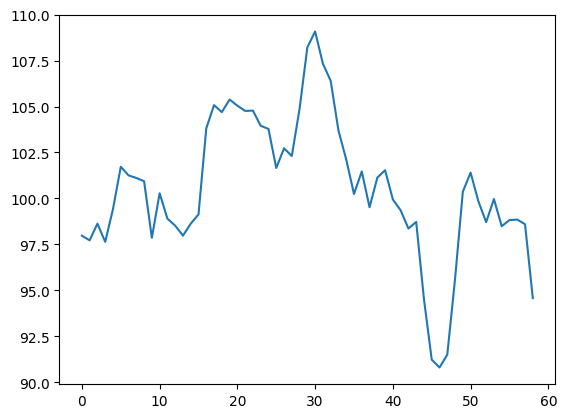

In [21]:
# for testing lasted genome from genomes checkpoints
import numpy as np
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/champs_topk/100.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

initializing
initializing finished
(500, 4) (1500, 3)
Today's selected symbols: ['LRCX', 'FSLR', 'WDC']
['LRCX', 'WDC', 'MSI']
[-0.00549654 -0.02371933 -0.01073856]
['LRCX', 'WDC', 'APH']
[-0.04474737 -0.12392178 -0.02669819]
['LRCX', 'WDC', 'APH']
[0.04954355 0.14666072 0.01979171]
['LRCX', 'WDC', 'AXP']
[-0.06133368  0.02096521 -0.01214926]
['LRCX', 'WDC', 'NFLX']
[-0.09457515 -0.10267368  0.01875234]
['LRCX', 'NFLX', 'APH']
[ 0.06025077 -0.00576759  0.02054057]
['LRCX', 'WDC', 'MSI']
[ 0.03779397  0.03438212 -0.00083117]
['LRCX', 'WDC', 'APH']
[0.00117901 0.00085775 0.06473722]
['LRCX', 'WDC', 'FSLR']
[ 0.02734649 -0.01767672  0.04936072]
['LRCX', 'WDC', 'APH']
[ 0.00331139  0.03606229 -0.00318063]
['LRCX', 'WDC', 'APH']
[-0.00063474 -0.04178949 -0.02477942]
['LRCX', 'WDC', 'BEN']
[-0.02002708  0.01563583  0.00221237]
['LRCX', 'WDC', 'MSI']
[ 0.02130053  0.04196717 -0.01925728]
['LRCX', 'APH', 'FSLR']
[-0.00977239 -0.02        0.0493534 ]
['LRCX', 'WDC', 'WRB']
[ 0.01486733 -0.05758

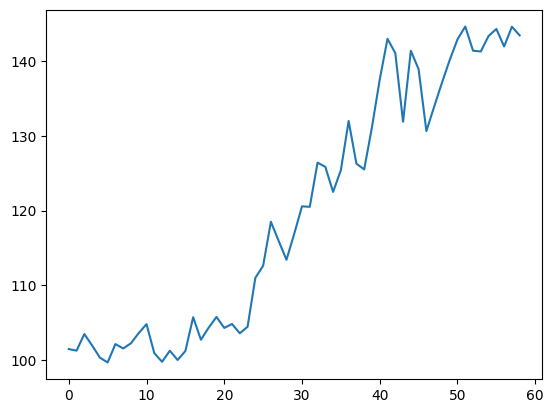

In [22]:
import numpy as np
topk_champs = os.listdir("./model_archive/tensorneat_checkpoints/champs_topk/")
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/genomes/610.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

In [16]:
import yfinance as yf
import pandas as pd
import os

# Get the last date in merged_df
last_date = merged_df.index.max()
print(f"Last date in merged_df: {last_date}")


# Fetch historical data for all symbols in live_syms
for symbol in live_syms:
    try:
        print(f"Fetching data for {symbol}...")
        # Fetch data from the last date until now
        symbol_history = yf.download(symbol, start=last_date, progress=False)
        symbol_history.reset_index(inplace=True)
        symbol_history.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
        print(symbol_history.head())
        # Save the data to a CSV file
        output_path = f"hist_data/stocks/single/{symbol}_history.csv"
        symbol_history.to_csv(output_path, index=False)
        print(f"Saved {symbol} data to {output_path}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

Last date in merged_df: 2024-12-20
Fetching data for ABT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  111.540771  112.400052  109.871022  109.988200  12311900
1 2024-12-23  111.618881  111.814177  110.300665  111.316182   4028200
2 2024-12-24  112.058296  112.126648  110.915835  111.452890   1480000
3 2024-12-26  112.556282  113.083570  111.140421  111.511473   2960500
4 2024-12-27  112.282875  113.220274  111.814180  112.302408   2829500
Saved ABT data to hist_data/stocks/single/ABT_history.csv
Fetching data for ADM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  48.230350  48.688868  47.045844  47.189133  12132700
1 2024-12-23  48.153927  48.268555  47.408837  47.762276   2592200
2 2024-12-24  48.364086  48.430953  47.743175  48.153931   1434600
3 2024-12-26  48.344978  48.612446  48.029746  48.096612   1627600
4 2024-12-27  48.316319  48.899015  47.924664  48.029742   1537700
Saved ADM data to hist_data/stocks/single/ADM_history.csv
Fetching data for AES...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  12.104464  12.206886  11.508551  11.508551  25105700
1 2024-12-23  12.160331  12.188264  11.899619  12.002042  10108300
2 2024-12-24  12.123086  12.151019  11.992730  12.104463   3967400
3 2024-12-26  11.955484  12.095151  11.880995  12.067218   7272100
4 2024-12-27  11.871685  11.946174  11.713396  11.871685   9280700
Saved AES data to hist_data/stocks/single/AES_history.csv
Fetching data for AJG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  280.642944  283.953952  274.585958  277.093999  2774900
1 2024-12-23  282.040680  282.506602  278.382704  279.225333  1935200
2 2024-12-24  285.847351  285.996043  281.108839  282.744512  1045800
3 2024-12-26  285.857239  286.610652  283.696167  284.062951  1173300
4 2024-12-27  284.053101  286.491742  282.724734  285.341806  7622800
Saved AJG data to hist_data/stocks/single/AJG_history.csv
Fetching data for ALB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  86.847923  88.699503  85.740889  86.083780  3685400
1 2024-12-23  87.386734  88.033321  86.318895  87.220192  2003000
2 2024-12-24  88.160675  88.307627  86.191540  87.621860   595100
3 2024-12-26  87.337753  88.591732  86.661777  87.690436  1194900
4 2024-12-27  86.495239  89.003197  85.525366  86.838123  1397000
Saved ALB data to hist_data/stocks/single/ALB_history.csv
Fetching data for ALL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  189.833862  191.167682  183.802259  184.802613  2351800
1 2024-12-23  189.902512  190.108461  188.009657  188.843300  1336100
2 2024-12-24  191.756134  192.050362  189.206180  190.137888   453200
3 2024-12-26  191.854187  192.148415  190.775372  191.697278   563300
4 2024-12-27  190.069244  192.020926  188.882531  190.422315  1094400
Saved ALL data to hist_data/stocks/single/ALL_history.csv
Fetching data for AMP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  523.841614  527.228099  512.943827  513.140727  1498700
1 2024-12-23  525.918823  526.096016  520.238630  521.547895   427100
2 2024-12-24  530.398071  531.490788  524.648899  528.527606   145100
3 2024-12-26  533.951904  534.572108  528.389779  528.389779   213700
4 2024-12-27  527.612122  535.359681  525.889347  532.032260   308300
Saved AMP data to hist_data/stocks/single/AMP_history.csv
Fetching data for AMZN...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  224.919998  226.210007  218.729996  219.839996  88279200
1 2024-12-23  225.059998  226.880005  223.899994  225.009995  28070000
2 2024-12-24  229.050003  229.139999  226.130005  226.940002  15007500
3 2024-12-26  227.050003  228.500000  226.669998  228.500000  16146700
4 2024-12-27  223.750000  226.029999  220.899994  225.600006  27367100
Saved AMZN data to hist_data/stocks/single/AMZN_history.csv
Fetching d

C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.002792  67.675553  66.369033  66.534784  2859700
1 2024-12-23  66.846786  66.963791  66.398282  66.515286   574400
2 2024-12-24  67.168541  67.168541  66.447035  66.768790   381800
3 2024-12-26  67.168541  67.509793  66.759038  66.924788   670600
4 2024-12-27  66.720039  67.344046  66.525040  66.885790   517900
Saved AOS data to hist_data/stocks/single/AOS_history.csv
Fetching data for APH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  70.040947  70.636363  68.423391  68.780642  12193100
1 2024-12-23  70.447807  70.656203  69.574531  70.249338   2970600
2 2024-12-24  71.112694  71.172233  70.269180  70.467657   1660900
3 2024-12-26  71.013458  71.251631  70.537128  70.705828   2882700
4 2024-12-27  70.199715  70.884447  69.733303  70.457731   4072300
Saved APH data to hist_data/stocks/single/APH_history.csv
Fetching data for AXON...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  631.690002  633.210022  605.099976  607.950012  7032800
1 2024-12-23  624.140015  642.530029  616.969971  634.640015   626700
2 2024-12-24  631.250000  631.780029  619.070007  619.669983   260500
3 2024-12-26  623.799988  630.000000  620.960022  630.000000   525800
4 2024-12-27  610.979980  622.460022  606.549988  620.950012   392100
Saved AXON data to hist_data/stocks/single/AXON_history.csv
Fetching data for AXP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  294.812164  298.829870  288.247627  288.593135  6232400
1 2024-12-23  294.960266  295.907951  291.396671  292.670102  1902400
2 2024-12-24  299.560364  299.718311  294.170536  295.443967   862900
3 2024-12-26  300.083588  300.972046  297.141901  297.605863  1228900
4 2024-12-27  297.181366  301.169459  294.871440  296.983954  1676000
Saved AXP data to hist_data/stocks/single/AXP_history.csv
Fetching data for BAX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  28.975824  29.457117  28.651688  28.818667  12194900
1 2024-12-23  28.661510  29.015114  28.239151  28.779377   4988400
2 2024-12-24  28.563290  28.651691  28.357022  28.494534   1577900
3 2024-12-26  28.779377  28.916891  28.288261  28.484708   2534200
4 2024-12-27  28.681154  28.838311  28.504352  28.563286   2773300
Saved BAX data to hist_data/stocks/single/BAX_history.csv
Fetching data for BBY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  81.185165  81.555267  79.192303  79.543428  5213600
1 2024-12-23  80.966888  81.754543  80.217194  81.052300  2049200
2 2024-12-24  82.418839  82.418839  80.834045  81.004862  1025000
3 2024-12-26  84.810257  85.094946  82.001280  82.001280  2630100
4 2024-12-27  83.538628  84.506590  83.149550  84.259854  1773800
Saved BBY data to hist_data/stocks/single/BBY_history.csv
Fetching data for BDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  175.203308  176.457620  171.994425  172.340708  3949051
1 2024-12-23  174.249115  175.349515  173.371854  174.172152  2268866
2 2024-12-24  174.641556  174.780069  172.517689  174.464568   626206
3 2024-12-26  175.541901  176.372966  173.341085  174.164459  1468651
4 2024-12-27  175.826630  177.057851  174.464586  174.487662  1807385
Saved BDX data to hist_data/stocks/single/BDX_history.csv
Fetching data for BEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  19.038290  19.437825  18.527258  18.564423  9415800
1 2024-12-23  19.010416  19.159082  18.833879  18.973251  3446200
2 2024-12-24  19.400658  19.437825  18.973249  19.084748  1350900
3 2024-12-26  19.474993  19.577200  19.224123  19.233415  2262400
4 2024-12-27  19.196245  19.530740  19.159080  19.363493  2362500
Saved BEN data to hist_data/stocks/single/BEN_history.csv
Fetching data for BKR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  39.327747  39.464301  38.352357  38.410882  17974900
1 2024-12-23  39.161930  39.269220  38.703495  39.025372   4094300
2 2024-12-24  39.786179  39.893472  38.908326  39.200942   2122000
3 2024-12-26  39.873966  39.893474  39.278977  39.786181   2289600
4 2024-12-27  39.795937  40.108061  39.522828  39.708151   3282500
Saved BKR data to hist_data/stocks/single/BKR_history.csv
Fetching data for BK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  75.603348  75.992949  74.113093  74.902053  13075300
1 2024-12-23  75.554626  75.632550  74.824112  74.940997   2670000
2 2024-12-24  76.022171  76.265676  75.320876  75.564381   1236500
3 2024-12-26  76.314369  76.450731  75.554636  75.729959   1970200
4 2024-12-27  75.554626  76.421502  75.077359  75.885797   2072300
Saved BK data to hist_data/stocks/single/BK_history.csv
Fetching data for BLDR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  150.500000  150.919998  145.850006  146.000000  4308000
1 2024-12-23  149.029999  150.389999  147.009995  149.139999  1722800
2 2024-12-24  148.820007  149.979996  147.690002  149.000000   588800
3 2024-12-26  148.179993  148.800003  146.029999  147.750000   959800
4 2024-12-27  145.080002  148.490005  144.380005  147.520004  1160600
Saved BLDR data to hist_data/stocks/single/BLDR_history.csv
Fetching data for BRO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  102.034668  102.956579  101.023544  101.410151  2726000
1 2024-12-23  101.905800  102.044581  100.745971  101.489447   773000
2 2024-12-24  102.946663  103.035884  101.301106  101.638145   338300
3 2024-12-26  102.837616  102.976398  102.064402  102.064402   588000
4 2024-12-27  101.995018  102.986320  101.489452  102.302319   676500
Saved BRO data to hist_data/stocks/single/BRO_history.csv
Fetching data for BSX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  88.949997  89.669998  87.250000  88.000000  15909900
1 2024-12-23  89.860001  89.989998  88.360001  89.269997   3833800
2 2024-12-24  91.070000  91.089996  89.660004  89.860001   1880000
3 2024-12-26  91.449997  91.550003  90.589996  90.680000   2601600
4 2024-12-27  90.660004  91.500000  90.230003  90.900002   3177600
Saved BSX data to hist_data/stocks/single/BSX_history.csv
Fetching data for BWA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  31.406277  31.563901  30.795491  30.795491  7655000
1 2024-12-23  31.524494  31.613157  31.140290  31.248654  1907500
2 2024-12-24  31.701822  31.751079  31.337319  31.514645   718100
3 2024-12-26  31.780628  31.928401  31.455534  31.632859  1210000
4 2024-12-27  31.711670  32.145134  31.406277  31.485088  1191700
Saved BWA data to hist_data/stocks/single/BWA_history.csv
Fetching data for CAT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  359.752899  365.109272  351.104030  352.342398  5142000
1 2024-12-23  359.114136  360.057639  355.290935  358.603048  1804900
2 2024-12-24  361.256683  361.256683  356.431013  358.190277   886000
3 2024-12-26  360.814362  361.178002  357.620183  358.779909  1097900
4 2024-12-27  358.593170  361.089552  355.536602  357.148448  1245800
Saved CAT data to hist_data/stocks/single/CAT_history.csv
Fetching data for CCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  26.676685  27.015121  25.322944  25.661380  61015000
1 2024-12-23  25.611610  26.417885  25.143774  26.397976  35169600
2 2024-12-24  25.671335  25.930137  25.303037  25.880368  10234900
3 2024-12-26  25.541931  25.711149  25.253267  25.362759  12363700
4 2024-12-27  24.964602  25.422486  24.775475  25.293083  14967400
Saved CCL data to hist_data/stocks/single/CCL_history.csv
Fetching data for CE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.043365  68.392304  66.527971  66.577815  7876500
1 2024-12-23  68.990463  69.419162  67.943647  68.282614  2011600
2 2024-12-24  68.192894  69.199838  67.933679  68.960559  1487200
3 2024-12-26  68.940628  69.060260  67.853924  68.133075  1222100
4 2024-12-27  68.551811  69.927630  68.073261  68.631563  2000800
Saved CE data to hist_data/stocks/single/CE_history.csv
Fetching data for CLX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  156.754547  157.288372  155.305583  156.764075  4020600
1 2024-12-23  155.467636  156.354178  153.360933  156.335109   766100
2 2024-12-24  155.791718  155.896577  154.562015  155.381822   399400
3 2024-12-26  156.306519  156.706887  155.343728  155.381852   601100
4 2024-12-27  155.381836  156.725940  154.638292  155.772677   596100
Saved CLX data to hist_data/stocks/single/CLX_history.csv
Fetching data for CMCSA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  34.116108  34.196442  33.303819  33.553752  64062787
1 2024-12-23  33.901878  34.107181  33.625164  33.946509  17799054
2 2024-12-24  34.276783  34.294637  33.660870  33.785839   7995138
3 2024-12-26  34.142887  34.330340  34.000068  34.142887  11549742
4 2024-12-27  33.857250  34.142888  33.643020  33.776912  16425611
Saved CMCSA data to hist_data/stocks/single/CMCSA_history.csv
Fetching data for CME...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  228.395264  230.099633  225.589761  226.930272  3172400
1 2024-12-23  227.897354  228.443143  225.790831  227.887784  1620100
2 2024-12-24  229.295319  229.381491  227.906930  227.954808   478400
3 2024-12-26  229.046371  229.448525  228.117584  228.337808  1174700
4 2024-12-27  229.134689  230.410389  227.378160  227.378160  1384000
Saved CME data to hist_data/stocks/single/CME_history.csv
Fetching data for COF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  175.727844  177.901702  171.419497  172.216246  5164300
1 2024-12-23  177.026276  177.400065  174.272072  174.498305  2095300
2 2024-12-24  179.141113  179.259161  176.711513  176.888577   931300
3 2024-12-26  179.377167  179.750956  177.065599  177.803332  1255600
4 2024-12-27  177.272186  179.859173  176.544285  178.127951  1209100
Saved COF data to hist_data/stocks/single/COF_history.csv
Fetching data for CRM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  341.421051  344.202908  328.992213  330.581811  14932300
1 2024-12-23  340.675964  341.619815  334.496306  340.030186   5330300
2 2024-12-24  342.196014  342.712661  338.619358  340.775297   1811000
3 2024-12-26  339.503601  342.643109  338.818074  342.643109   3483300
4 2024-12-27  336.254852  340.050053  333.095454  338.142523   3220400
Saved CRM data to hist_data/stocks/single/CRM_history.csv
Fetching data for CSCO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  56.745186  56.997299  55.533096  55.823997  69544600
1 2024-12-23  57.191231  57.230019  56.357313  56.367011  18671200
2 2024-12-24  58.034840  58.034840  57.016685  57.016685   9922300
3 2024-12-26  58.160896  58.238472  57.598489  57.811814   8524500
4 2024-12-27  57.802124  58.199689  57.346377  57.763336  13021400
Saved CSCO data to hist_data/stocks/single/CSCO_history.csv
Fetching data for CSGP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  71.440002  71.860001  69.610001  69.889999  7036000
1 2024-12-23  72.739998  72.860001  70.110001  70.120003  2637900
2 2024-12-24  72.949997  73.000000  71.930000  72.330002  1159700
3 2024-12-26  73.099998  73.519997  71.800003  72.379997  1293000
4 2024-12-27  72.220001  72.800003  71.690002  72.279999  1702400
Saved CSGP data to hist_data/stocks/single/CSGP_history.csv
Fetching data for CVX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  135.198746  135.198746  133.021934  133.277477  32209200
1 2024-12-23  135.312317  135.671968  133.958902  134.848557   8156500
2 2024-12-24  136.135712  136.324996  134.640337  135.435356   3556100
3 2024-12-26  136.268234  136.580561  135.246079  135.974841   4492600
4 2024-12-27  136.287140  137.905556  135.709812  136.561601   5296500
Saved CVX data to hist_data/stocks/single/CVX_history.csv
Fetching data for C...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  66.973160  68.008877  65.850323  66.101994  27720100
1 2024-12-23  67.534569  67.641045  66.663411  67.137709   8248000
2 2024-12-24  68.725166  68.928437  67.699131  67.854001   6544900
3 2024-12-26  69.063950  69.180107  68.250867  68.279904   6341700
4 2024-12-27  68.725166  69.238184  68.279906  68.589652   7743100
Saved C data to hist_data/stocks/single/C_history.csv
Fetching data for DE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  425.025391  428.966189  418.391893  418.657252  2446400
1 2024-12-23  424.917328  425.163013  419.630179  425.163013  1093900
2 2024-12-24  425.369385  426.106440  421.310662  423.177863   383200
3 2024-12-26  426.352142  427.934370  423.010831  424.337536   444900
4 2024-12-27  422.637360  427.659179  419.718619  424.868170   735300
Saved DE data to hist_data/stocks/single/DE_history.csv
Fetching data for DG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.170692  74.568725  71.636850  71.636850  5865400
1 2024-12-23  72.442627  73.568775  71.238804  73.355193  5089400
2 2024-12-24  72.462051  72.821258  71.957228  72.326137  1542300
3 2024-12-26  73.423157  73.607615  71.996057  72.568837  3600700
4 2024-12-27  73.675568  74.287182  72.995996  73.190157  2659700
Saved DG data to hist_data/stocks/single/DG_history.csv
Fetching data for DHI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  137.577240  138.720354  135.300877  135.921693  7848000
1 2024-12-23  138.050278  138.148828  135.813340  137.232361  2410100
2 2024-12-24  138.996292  139.203226  137.074687  137.261908  1162200
3 2024-12-26  139.410172  140.277363  137.853175  137.961574  1677400
4 2024-12-27  138.237503  140.021147  137.656097  138.533138  1624300
Saved DHI data to hist_data/stocks/single/DHI_history.csv
Fetching data for DIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  110.804588  111.734309  109.222091  109.400122  17955300
1 2024-12-23  110.181488  110.626563  109.103407  110.389190   6037200
2 2024-12-24  111.328789  111.506820  109.973779  110.033120   2475000
3 2024-12-26  111.318909  112.080483  110.636454  110.893612   4781400
4 2024-12-27  110.329849  110.893614  109.647394  110.596893   4523800
Saved DIS data to hist_data/stocks/single/DIS_history.csv
Fetching data for DLR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  173.230225  176.043500  170.523646  171.522844  4801700
1 2024-12-23  173.133224  173.763782  171.270640  173.346647  2167100
2 2024-12-24  175.005508  175.005508  172.628774  173.036213   683700
3 2024-12-26  174.132431  174.607784  173.162334  173.831703   693500
4 2024-12-27  172.813095  174.248835  172.027319  172.890705   822900
Saved DLR data to hist_data/stocks/single/DLR_history.csv
Fetching data for DOV...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  187.169693  188.504703  185.419330  186.437899  2381100
1 2024-12-23  186.714798  187.337812  184.885336  186.269795   611000
2 2024-12-24  188.217926  188.415704  186.358783  186.358783   215500
3 2024-12-26  188.791489  189.365054  187.169688  187.377349   299000
4 2024-12-27  186.240112  189.365050  185.567650  187.209233   457400
Saved DOV data to hist_data/stocks/single/DOV_history.csv
Fetching data for DPZ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  419.487579  425.728017  417.351672  421.899118  932700
1 2024-12-23  419.841919  420.875418  413.847556  418.906825  332800
2 2024-12-24  424.231873  425.363808  418.148926  420.816362  214900
3 2024-12-26  425.826447  427.529291  421.603805  421.751474  300900
4 2024-12-27  422.873505  425.698431  421.200218  421.200218  291000
Saved DPZ data to hist_data/stocks/single/DPZ_history.csv
Fetching data for DTE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  116.255753  116.555628  112.889382  113.121551  3035900
1 2024-12-23  116.323479  116.478258  115.036905  116.130012   899000
2 2024-12-24  116.816826  116.865189  116.149354  116.149354   309900
3 2024-12-26  117.136040  117.387552  116.120330  116.323472   533400
4 2024-12-27  117.387550  118.093717  116.178367  116.458898  1074800
Saved DTE data to hist_data/stocks/single/DTE_history.csv
Fetching data for DXCM...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  80.040001  81.510002  75.470001  75.470001  11578500
1 2024-12-23  79.540001  80.250000  77.800003  78.900002   2389400
2 2024-12-24  80.239998  80.830002  78.589996  79.559998   1153100
3 2024-12-26  80.570000  80.669998  79.250000  79.540001   1350500
4 2024-12-27  80.239998  80.500000  79.629997  80.029999   1797800
Saved DXCM data to hist_data/stocks/single/DXCM_history.csv
Fetching data for EA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  146.956665  148.806053  145.862936  146.240772  4055500
1 2024-12-23  146.459503  146.777669  145.664065  146.777669  1708600
2 2024-12-24  148.328781  148.796101  146.171165  146.568892   778600
3 2024-12-26  148.219421  148.637023  147.105802  147.493576   883400
4 2024-12-27  147.274826  148.000672  146.191049  147.612898  1023500
Saved EA data to hist_data/stocks/single/EA_history.csv
Fetching data for ED...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  86.348320  86.827873  85.149437  85.149437  4876400
1 2024-12-23  86.003044  86.214049  85.159033  86.214049  1979000
2 2024-12-24  85.916733  86.060600  85.456359  85.744093   653900
3 2024-12-26  85.926308  86.444226  85.360439  85.581036  1879800
4 2024-12-27  85.897537  86.281181  85.197394  85.360440  1319600
Saved ED data to hist_data/stocks/single/ED_history.csv
Fetching data for EFX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  256.398376  260.872931  252.578652  252.896128  1788100
1 2024-12-23  256.457916  257.261546  253.670009  255.366588   480400
2 2024-12-24  259.216064  259.523625  252.201652  255.366592   208700
3 2024-12-26  256.765533  259.940390  256.279395  256.299227   432500
4 2024-12-27  253.967682  257.013540  252.677898  254.354615   406600
Saved EFX data to hist_data/stocks/single/EFX_history.csv
Fetching data for EIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.027359  74.157695  72.416858  72.491334  5974300
1 2024-12-23  74.213554  74.222866  73.040584  74.027365  1959100
2 2024-12-24  74.716263  74.753501  73.934280  74.381128   997100
3 2024-12-26  74.483521  74.688326  74.055295  74.334569  1000200
4 2024-12-27  74.278709  74.781411  73.915648  73.962190   985500
Saved EIX data to hist_data/stocks/single/EIX_history.csv
Fetching data for EL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  73.071266  74.240645  72.688026  72.717505  7621000
1 2024-12-23  73.454498  74.063756  72.363735  72.648710  2995200
2 2024-12-24  73.778778  73.985138  72.186852  73.474146  1162700
3 2024-12-26  73.700165  74.574739  73.218659  73.582242  1740500
4 2024-12-27  73.326752  73.916352  72.412869  72.835417  1853400
Saved EL data to hist_data/stocks/single/EL_history.csv
Fetching data for EMN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.705070  88.096949  84.952335  85.382453  2504100
1 2024-12-23  87.179367  88.049157  86.290464  87.294067  1175500
2 2024-12-24  87.523453  87.666826  86.806596  87.102894   309200
3 2024-12-26  87.466118  87.848443  86.902187  86.988213   695100
4 2024-12-27  87.685944  88.603520  87.188926  87.236712  1104100
Saved EMN data to hist_data/stocks/single/EMN_history.csv
Fetching data for EQIX...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  901.518555  910.512156  893.808372  897.046085  1434600
1 2024-12-23  913.545776  916.151483  897.425336  906.487005   488700
2 2024-12-24  923.676941  923.676941  911.708161  913.545787   168400
3 2024-12-26  922.101807  925.835333  916.861197  922.957419   234800
4 2024-12-27  916.530518  923.832358  913.467868  913.847071   289700
Saved EQIX data to hist_data/stocks/single/EQIX_history.csv
Fetching data for EQR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.799767  68.531457  66.459929  67.011064  5177000
1 2024-12-23  67.885300  68.046839  67.001574  67.229630  1300900
2 2024-12-24  68.626495  68.740520  67.533715  67.676253   568700
3 2024-12-26  68.769020  68.940064  68.227382  68.464943   747200
4 2024-12-27  68.018318  69.044581  67.856779  68.151351   946100
Saved EQR data to hist_data/stocks/single/EQR_history.csv
Fetching data for EQT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  42.360260  43.000736  41.798606  41.966118  12908800
1 2024-12-23  43.217514  43.355463  42.222307  42.370111   4813900
2 2024-12-24  43.926968  44.104327  42.990883  43.444144   2013600
3 2024-12-26  43.532825  43.986086  43.069709  43.513118   2712300
4 2024-12-27  43.670773  44.321104  43.316045  43.522968   4508300
Saved EQT data to hist_data/stocks/single/EQT_history.csv
Fetching data for ESS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  271.092133  274.426319  267.796139  267.901243  1417600
1 2024-12-23  271.636627  272.219410  268.550843  269.706817   386400
2 2024-12-24  273.986847  274.005944  269.668615  271.894613   121600
3 2024-12-26  274.865753  276.289255  272.955039  273.404058   231600
4 2024-12-27  271.732208  275.668275  270.776851  273.136584   298700
Saved ESS data to hist_data/stocks/single/ESS_history.csv
Fetching data for EXPE...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  183.270645  184.034484  175.959664  175.959664  4134800
1 2024-12-23  187.327896  187.952856  181.911625  184.748724  1461500
2 2024-12-24  188.161179  188.716707  186.742636  187.744543   366200
3 2024-12-26  188.597641  188.766278  186.990618  188.200850   879500
4 2024-12-27  184.619766  188.577823  183.221053  186.306151  1395000
Saved EXPE data to hist_data/stocks/single/EXPE_history.csv
Fetching data fo

C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  36.430222  36.600638  35.748554  35.836197  15509000
1 2024-12-23  36.264679  36.478915  36.016356  36.362058   4135000
2 2024-12-24  36.571430  36.586037  36.152692  36.342584   2134600
3 2024-12-26  36.235462  36.444831  36.181902  36.332845   2531800
4 2024-12-27  35.553799  36.001754  35.217837  35.982277   5252600
Saved FAST data to hist_data/stocks/single/FAST_history.csv
Fetching data for FCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  38.181255  38.603745  37.296974  37.316625  22372300
1 2024-12-23  38.564442  38.652870  37.886495  38.240204   8562500
2 2024-12-24  38.534969  38.701998  38.132131  38.682347   3962500
3 2024-12-26  38.505489  38.633220  38.240205  38.358112   6127100
4 2024-12-27  38.181255  38.495666  37.886496  38.220558   7892500
Saved FCX data to hist_data/stocks/single/FCX_history.csv
Fetching data for FDS...
        Date       Close        High         Low        Open  Volume
0 2024-12-20  477.962738  480.097916  464.924333  479.020447  922800
1 2024-12-23  483.715820  484.200179  474.502931  474.502931  264300
2 2024-12-24  485.702728  486.345252  482.094685  484.259517  110700
3 2024-12-26  485.959717  487.294207  481.827766  482.163855  163900
4 2024-12-27  480.967773  487.333758  477.300422  484.526403  155200
Saved FDS data to hist_data/stocks/single/FDS_history.csv
Fetching data for FDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  269.356750  288.415773  264.638375  287.204445  8126800
1 2024-12-23  262.792084  268.751064  258.962678  268.643621  3500700
2 2024-12-24  265.556641  266.230694  261.414654  262.782288  1013100
3 2024-12-26  272.218994  273.821071  264.052214  264.101076  1777300
4 2024-12-27  273.879700  275.091058  270.148018  270.919737  1553200
Saved FDX data to hist_data/stocks/single/FDX_history.csv
Fetching data for FFIV...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  252.250000  254.009995  248.020004  249.259995  1233800
1 2024-12-23  254.410004  254.809998  250.880005  251.750000   269700
2 2024-12-24  256.200012  257.040009  253.899994  253.990005   172600
3 2024-12-26  257.119995  257.899994  254.699997  255.630005   204200
4 2024-12-27  255.630005  256.869995  253.669998  254.110001   212200


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved FFIV data to hist_data/stocks/single/FFIV_history.csv
Fetching data for FRT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  105.896599  107.003629  103.881235  103.881235  1825000
1 2024-12-23  106.095299  106.303460  105.045037  105.480287   480200
2 2024-12-24  106.663017  106.823866  105.745220  105.745220   210100
3 2024-12-26  106.719788  107.041486  105.508677  106.085848   269500
4 2024-12-27  105.432968  106.918472  105.073422  106.180452   383300
Saved FRT data to hist_data/stocks/single/FRT_history.csv
Fetching data for FSLR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  182.389999  183.009995  173.360001  174.460007  3462900
1 2024-12-23  186.360001  186.830002  180.520004  183.399994  1718400
2 2024-12-24  186.210007  189.139999  184.500000  186.839996   671900
3 2024-12-26  183.710007  186.500000  183.240005  184.509995   732000
4 2024-12-27  182.630005  184.740005  180.520004  184.039993  1034100
Saved FSLR data to hist_data/stocks/single/FSLR_history.csv
Fetching data fo

C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  97.190002  97.830002  93.360001  93.720001  13324400
1 2024-12-23  96.419998  97.070000  95.339996  96.930000   3107900
2 2024-12-24  97.809998  97.830002  96.320000  96.650002   1764900
3 2024-12-26  97.290001  97.599998  96.730003  97.160004   1661500
4 2024-12-27  96.080002  96.510002  94.800003  96.510002   2774700
Saved FTNT data to hist_data/stocks/single/FTNT_history.csv
Fetching data for GIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  59.982204  60.821446  59.718175  60.642279  10672900
1 2024-12-23  59.925625  60.246234  59.397565  59.557868   3380200
2 2024-12-24  60.104794  60.189661  59.576730  59.595590   1220400
3 2024-12-26  60.123650  60.689433  59.850192  59.878479   2212100
4 2024-12-27  60.302814  60.519697  59.878478  59.982205   1984400
Saved GIS data to hist_data/stocks/single/GIS_history.csv
Fetching data for GLW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  46.427631  46.427631  45.671992  45.829008  11445800
1 2024-12-23  46.614086  46.682780  46.152851  46.398188   2852200
2 2024-12-24  47.006630  47.006630  46.162669  46.466885   1592800
3 2024-12-26  47.094952  47.153830  46.574834  46.722038   1960200
4 2024-12-27  46.888866  47.173459  46.565023  46.722039   2255000
Saved GLW data to hist_data/stocks/single/GLW_history.csv
Fetching data for GOOG...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  192.211731  193.382162  185.647275  186.284792  45319700
1 2024-12-23  195.229950  195.728011  190.886858  193.277544  15235900
2 2024-12-24  196.803833  196.903436  194.441022  195.409253   6809800
3 2024-12-26  196.335663  197.391550  195.110422  195.977058   7907900
4 2024-12-27  193.287521  196.036828  191.227548  195.708106  14693000
Saved GOOG data to hist_data/stocks/single/GOOG_history.csv
Fetching data for GPN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  110.709244  111.519576  108.120137  108.396834  3300500
1 2024-12-23  110.491844  110.748781  108.298015  109.622221  1053900
2 2024-12-24  111.648056  111.875340  110.145971  110.145971   439200
3 2024-12-26  112.418861  112.735089  110.412795  110.867371   821200
4 2024-12-27  111.025475  112.833902  110.570899  111.489935  1038600
Saved GPN data to hist_data/stocks/single/GPN_history.csv
Fetching data for HIG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  107.652176  107.957026  104.347970  104.879004  5819000
1 2024-12-23  107.898018  108.075029  106.826114  107.022798  1095600
2 2024-12-24  108.733910  108.753574  107.445665  107.888190   397800
3 2024-12-26  109.137108  109.235446  108.173378  108.517565   574200
4 2024-12-27  108.281540  109.559955  107.957018  108.242203   856000
Saved HIG data to hist_data/stocks/single/HIG_history.csv
Fetching data for HRL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  30.016279  30.215250  29.864682  29.978379  4859800
1 2024-12-23  29.893103  30.044700  29.694132  29.826779  1845800
2 2024-12-24  29.949955  30.092077  29.703609  29.836256   844000
3 2024-12-26  30.016279  30.101553  29.732033  29.798358  1253000
4 2024-12-27  30.177351  30.319473  29.826781  29.826781  1718600
Saved HRL data to hist_data/stocks/single/HRL_history.csv
Fetching data for HSIC...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  69.820000  70.330002  68.430000  68.949997  2761500
1 2024-12-23  70.059998  70.750000  69.459999  69.589996  1111900
2 2024-12-24  70.010002  70.239998  69.440002  69.949997   421000
3 2024-12-26  70.970001  72.540001  69.760002  70.000000   851500
4 2024-12-27  70.419998  71.129997  69.839996  70.269997   501200
Saved HSIC data to hist_data/stocks/single/HSIC_history.csv
Fetching data for HST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  16.888893  17.037367  16.127964  16.174363  19799300
1 2024-12-23  16.768255  16.898169  16.619782  16.870332   4286000
2 2024-12-24  16.907452  16.953851  16.712581  16.786817   1710000
3 2024-12-26  16.963129  17.018806  16.786816  16.879612   3034500
4 2024-12-27  16.684744  16.926014  16.545550  16.833218   7022200
Saved HST data to hist_data/stocks/single/HST_history.csv
Fetching data for ICE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  148.626511  149.644973  146.342385  146.688471  6446800
1 2024-12-23  148.478195  148.735278  147.103764  147.716815  2853800
2 2024-12-24  148.774857  148.883625  147.924488  148.478214  1084600
3 2024-12-26  149.328583  149.674654  147.528959  147.528959  1168100
4 2024-12-27  148.636414  149.654876  147.855253  148.201339  1212400
Saved ICE data to hist_data/stocks/single/ICE_history.csv
Fetching data for IEX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  208.450256  209.598606  203.140356  205.623541  1243600
1 2024-12-23  206.860199  208.597452  206.516684  207.174285   424000
2 2024-12-24  208.352097  208.764323  206.281138  206.281138   156300
3 2024-12-26  209.039154  210.393624  207.380422  207.959517   401800
4 2024-12-27  207.203751  209.480815  206.310585  207.360794   166100
Saved IEX data to hist_data/stocks/single/IEX_history.csv
Fetching data for IFF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  83.779762  84.835072  82.812398  83.300967  4203000
1 2024-12-23  82.851486  83.652739  81.932975  83.515940  1334600
2 2024-12-24  83.164162  83.574558  82.792852  83.056676   378400
3 2024-12-26  82.988281  83.486623  82.675598  82.802623   592600
4 2024-12-27  82.656052  83.369365  82.323828  82.372688   740700
Saved IFF data to hist_data/stocks/single/IFF_history.csv
Fetching data for INCY...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.839996  69.110001  66.889999  66.889999  6805500
1 2024-12-23  69.839996  70.190002  68.150002  68.580002  1611100
2 2024-12-24  69.910004  70.099998  68.919998  69.879997   395900
3 2024-12-26  69.559998  70.110001  69.250000  69.519997   764500
4 2024-12-27  69.230003  69.900002  68.190002  68.709999   966400
Saved INCY data to hist_data/stocks/single/INCY_history.csv
Fetching data for IP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  51.799694  51.837748  50.905445  51.057657  6737000
1 2024-12-23  51.837742  51.837742  50.753227  51.419156  2549000
2 2024-12-24  52.427563  52.465617  51.942385  52.180216   879400
3 2024-12-26  52.522694  52.655879  52.218270  52.418047  1743000
4 2024-12-27  51.837742  52.475128  51.628449  52.322916  1681200
Saved IP data to hist_data/stocks/single/IP_history.csv
Fetching data for IRM...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  101.441193  103.255750   98.941361   99.037878  5696100
1 2024-12-23  101.557022  101.672840   98.680760  100.852432  2095900
2 2024-12-24  101.904495  101.904495  100.485668  101.238514   767700
3 2024-12-26  102.049263  102.290560  100.543566  101.489453   879900
4 2024-12-27  101.074432  102.029966  100.408451  100.977915   954200


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved IRM data to hist_data/stocks/single/IRM_history.csv
Fetching data for ISRG...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  524.429993  530.969971  516.179993  521.450012  3933900
1 2024-12-23  527.219971  527.940002  520.030029  524.880005  1069800
2 2024-12-24  537.020020  537.359985  527.260010  528.010010   629200
3 2024-12-26  538.830017  540.130005  533.989990  534.859985   765700
4 2024-12-27  534.880005  537.340027  529.309998  536.010010  1013200
Saved ISRG data to hist_data/stocks/single/ISRG_history.csv
Fetching data for JBHT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  167.937469  169.071991  163.271174  166.240632  2140300
1 2024-12-23  168.243301  168.578734  166.270236  167.355428   513300
2 2024-12-24  169.259415  169.367919  167.394854  167.789476   180900
3 2024-12-26  169.693481  170.147293  167.986784  168.411001   268000
4 2024-12-27  169.693481  170.768814  167.769746  169.052241   298300
Saved JBHT data to hist_data/stocks/single/JBHT_history.csv
Fetching data for JCI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  79.621826  80.006901  77.281747  77.607583  6394200
1 2024-12-23  79.661514  80.068207  78.897735  79.195308  4021000
2 2024-12-24  80.336014  80.336014  79.334175  79.403609  1241100
3 2024-12-26  80.197151  80.623679  79.849979  80.107882  1348600
4 2024-12-27  79.175468  80.147558  78.858053  79.135791  1651800
Saved JCI data to hist_data/stocks/single/JCI_history.csv
Fetching data for KIM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  22.329638  22.510792  21.938726  21.967330  9672400
1 2024-12-23  22.339172  22.415448  22.129414  22.234293  3739800
2 2024-12-24  22.520327  22.558463  22.215223  22.234293  1557400
3 2024-12-26  22.510792  22.625204  22.377309  22.396378  1580800
4 2024-12-27  22.281967  22.606136  22.205692  22.405914  2023500
Saved KIM data to hist_data/stocks/single/KIM_history.csv
Fetching data for KMX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  84.269997  85.400002  82.120003  85.400002  4192700
1 2024-12-23  83.699997  84.199997  82.529999  84.110001  1864100
2 2024-12-24  84.910004  85.199997  83.629997  84.000000   901600
3 2024-12-26  85.169998  85.540001  83.790001  84.230003  1160300
4 2024-12-27  83.769997  85.309998  83.269997  84.099998  1319900
Saved KMX data to hist_data/stocks/single/KMX_history.csv
Fetching data for K...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)

1 Failed download:
['K']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-12-20 -> 2026-02-27) (Yahoo error = "No data found, symbol may be delisted")')
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Error fetching data for K: Length mismatch: Expected axis has 7 elements, new values have 6 elements
Fetching data for LEN...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  130.842148  132.557260  129.411299  130.662108  9358257
1 2024-12-23  130.766327  131.979243  130.017744  130.387293  3821997
2 2024-12-24  130.766327  132.007666  130.283069  130.283069  2198947
3 2024-12-26  131.372772  132.187701  129.648175  129.818746  2752945
4 2024-12-27  129.998779  132.320357  129.449176  130.766316  2101122
Saved LEN data to hist_data/stocks/single/LEN_history.csv
Fetching data for LH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  226.101730  227.249007  224.074220  225.350074  996900
1 2024-12-23  225.340179  226.081951  222.778600  225.448973  510600
2 2024-12-24  226.972092  227.585284  223.233566  224.657754  144100
3 2024-12-26  228.524857  229.147949  226.497346  226.517131  430800
4 2024-12-27  227.901779  229.860066  226.536930  227.288586  339800
Saved LH data to hist_data/stocks/single/LH_history.csv
Fetching data for LKQ...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  35.649483  36.065136  34.711846  34.992171  6251000
1 2024-12-23  35.639812  35.833140  35.088831  35.552815  1566500
2 2024-12-24  35.475487  35.697812  35.427156  35.697812  1320300
3 2024-12-26  35.765472  35.833137  35.282155  35.514149  1294500
4 2024-12-27  35.659149  35.929806  35.417491  35.485155  1193800
Saved LKQ data to hist_data/stocks/single/LKQ_history.csv
Fetching data for LRCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  71.138512  72.803266  69.662035  69.899855  29404500
1 2024-12-23  73.130280  73.318550  71.346611  71.693434  10406700
2 2024-12-24  73.159996  73.496907  72.565443  73.397816   5611700
3 2024-12-26  73.318550  73.883377  72.337536  72.585268   6297400
4 2024-12-27  72.733902  73.090636  71.980797  72.634811   5444100
Saved LRCX data to hist_data/stocks/single/LRCX_history.csv
Fetching data for MCD...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  286.008911  289.350972  282.705947  282.920934  7678000
1 2024-12-23  284.650665  286.419408  283.126225  285.598557  2492200
2 2024-12-24  287.289093  287.562710  284.162048  284.640870  1461000
3 2024-12-26  288.080597  288.706024  285.930760  286.321636  1433900
4 2024-12-27  286.927490  289.722318  286.067543  286.653873  1617200
Saved MCD data to hist_data/stocks/single/MCD_history.csv
Fetching data for MO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.280891  49.317505  48.374722  48.438794  27063800
1 2024-12-23  49.042912  49.290045  48.466258  49.280894   7199600
2 2024-12-24  48.942223  49.097826  48.868995  49.079519   5406800
3 2024-12-26  49.082188  49.250150  48.484990  48.783589   5230800
4 2024-12-27  48.876900  49.315464  48.615623  48.839574   6425500
Saved MO data to hist_data/stocks/single/MO_history.csv
Fetching data for MRK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  94.497452  96.068391  94.352885  95.249190  29289700
1 2024-12-23  95.769623  95.981646  94.642009  95.499762   8460500
2 2024-12-24  95.846710  96.029828  95.220267  95.625048   3713500
3 2024-12-26  96.251503  96.318966  95.335919  95.499758   4760300
4 2024-12-27  96.087654  96.714105  95.644322  95.894903   6173600
Saved MRK data to hist_data/stocks/single/MRK_history.csv
Fetching data for MSFT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  432.415924  439.487483  424.522302  428.959349  64263700
1 2024-12-23  431.078857  433.455851  428.682036  432.554569  19152500
2 2024-12-24  435.119751  435.387183  430.029025  430.484608   7164500
3 2024-12-26  433.911438  436.714334  432.445641  434.872143   8194200
4 2024-12-27  426.404053  431.049109  422.264119  430.435056  18117700
Saved MSFT data to hist_data/stocks/single/MSFT_history.csv
Fetching data for MSI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  464.861115  467.462696  455.028539  456.047406  2508300
1 2024-12-23  464.692902  465.167725  458.589601  463.871885   652500
2 2024-12-24  467.343964  467.353835  463.228920  464.880854   235400
3 2024-12-26  466.216278  466.977945  463.683948  465.375458   292300
4 2024-12-27  462.279236  465.533687  460.538278  463.357482   364800
Saved MSI data to hist_data/stocks/single/MSI_history.csv
Fetching data for MTD...
        Date        Close         High          Low         Open  Volume
0 2024-12-20  1230.739990  1240.660034  1197.119995  1206.069946  275200
1 2024-12-23  1234.390015  1236.329956  1219.150024  1219.439941   87700
2 2024-12-24  1246.300049  1248.199951  1229.770020  1233.770020   33600
3 2024-12-26  1245.280029  1247.020020  1234.430054  1234.430054   45200
4 2024-12-27  1234.229980  1245.760010  1228.869995  1231.359985   70700


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved MTD data to hist_data/stocks/single/MTD_history.csv
Fetching data for NDAQ...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  76.753387  77.622671  76.150818  76.437286  7181700
1 2024-12-23  76.990479  77.257186  76.269369  76.615103  1775300
2 2024-12-24  77.958519  77.998033  76.743508  77.049729   846400
3 2024-12-26  78.156097  78.432685  77.425107  77.543648  1842400
4 2024-12-27  77.464615  78.215358  77.109000  77.672056  1347000
Saved NDAQ data to hist_data/stocks/single/NDAQ_history.csv
Fetching data for NFLX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  90.904999  91.991997  89.049004  89.320999  45305000
1 2024-12-23  91.144997  91.500000  89.910004  91.342003  23394000
2 2024-12-24  93.211998  93.584999  91.169998  91.500000  23203000
3 2024-12-26  92.414001  93.049004  91.529999  92.839996  23403000
4 2024-12-27  90.754997  91.813004  89.449997  91.600998  32262000
Saved NFLX data to hist_data/stocks/single/NFLX_history.csv
Fetching data for NTAP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  115.532410  116.868667  112.264926  113.084240  3813600
1 2024-12-23  115.171516  115.776240  114.157132  115.347083  1457000
2 2024-12-24  115.912788  115.932300  114.654570  115.093482   441300
3 2024-12-26  115.434868  116.312701  114.547286  115.581175   733800
4 2024-12-27  114.079086  114.849628  112.781845  114.186377   995000
Saved NTAP data to hist_data/stocks/single/NTAP_history.csv
Fetching data for NVDA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open     Volume
0 2024-12-20  134.663162  135.243005  128.184939  129.774500  306528600
1 2024-12-23  139.631805  139.751768  135.083047  136.242733  176053500
2 2024-12-24  140.181671  141.861205  138.612093  139.961730  105157000
3 2024-12-26  139.891739  140.811501  137.692343  139.661806  116205600
4 2024-12-27  136.972519  138.981979  134.673160  138.512106  170582600
Saved NVDA data to hist_data/stocks/single/NVDA_history.csv
Fetching data for OMC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  85.643120  86.558725  83.773349  84.457645  6003400
1 2024-12-23  83.561317  85.392536  83.426386  85.238332  1809200
2 2024-12-24  83.262543  83.628783  82.857749  83.628783   823500
3 2024-12-26  84.264885  84.467282  82.597511  82.770995  1218300
4 2024-12-27  83.358917  84.380548  83.098695  83.570954  1164200
Saved OMC data to hist_data/stocks/single/OMC_history.csv
Fetching data for ON...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  65.500000  66.860001  63.939999  64.220001  12758500
1 2024-12-23  66.629997  66.989998  65.449997  65.500000   5257400
2 2024-12-24  67.900002  67.919998  66.419998  66.629997   3044800
3 2024-12-26  67.019997  67.949997  66.989998  67.050003   3659500
4 2024-12-27  66.010002  67.050003  65.480003  66.699997   4751900
Saved ON data to hist_data/stocks/single/ON_history.csv
Fetching data for ORCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  167.546234  169.126291  163.566445  165.640272  13810500
1 2024-12-23  167.032700  167.506715  165.087242  167.477090   6518200
2 2024-12-24  169.274445  169.629960  166.924092  167.585742   2451500
3 2024-12-26  169.541061  170.400232  168.375770  168.375770   4100100
4 2024-12-27  166.854935  169.017637  165.116853  168.257241   4344300
Saved ORCL data to hist_data/stocks/single/ORCL_history.csv
Fetching data for O...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.432659  50.153689  48.692901  48.692901  14467200
1 2024-12-23  49.629303  49.694851  49.104917  49.348383   5474900
2 2024-12-24  49.854031  49.854031  49.320278  49.516925   2585000
3 2024-12-26  49.694851  49.994499  49.526298  49.732308   7385900
4 2024-12-27  49.310925  50.078774  49.133009  49.563753   5373900
Saved O data to hist_data/stocks/single/O_history.csv
Fetching data for PAYX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  133.904800  134.451789  131.064345  131.064345  4925600
1 2024-12-23  133.712906  133.952810  132.407827  133.549773  1514700
2 2024-12-24  135.680099  135.977578  133.482585  133.722489   885800
3 2024-12-26  136.879639  137.100346  135.113949  135.373049  2364200
4 2024-12-27  135.564987  137.205923  134.931637  136.361470  2032100
Saved PAYX data to hist_data/stocks/single/PAYX_history.csv
Fetching data for PEG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  82.402222  82.518475  79.563772  79.796278  5833000
1 2024-12-23  82.566917  82.605661  81.181599  82.392541  1953600
2 2024-12-24  83.109421  83.157854  82.285981  82.431288   600800
3 2024-12-26  82.731606  83.051296  82.150355  82.818790   943300
4 2024-12-27  82.276283  82.479721  81.578779  82.072846  1356000
Saved PEG data to hist_data/stocks/single/PEG_history.csv
Fetching data for PEP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  146.918884  147.591998  144.726497  145.063054  19205200
1 2024-12-23  145.476547  146.553520  143.957273  146.553520   6822200
2 2024-12-24  146.938141  146.957376  144.630369  144.716907   3399800
3 2024-12-26  146.582367  147.293922  146.390055  146.668905   5528500
4 2024-12-27  147.015076  147.572790  145.447705  145.476551   4287000
Saved PEP data to hist_data/stocks/single/PEP_history.csv
Fetching data for PFG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.411415  74.661694  71.735293  71.995208  3446700
1 2024-12-23  74.507675  74.603937  73.660555  73.930098   900100
2 2024-12-24  74.892723  75.027491  74.064860  74.276640   271200
3 2024-12-26  75.412537  75.470299  74.555795  74.806082   372400
4 2024-12-27  74.806091  75.720596  74.469172  74.844597   726800
Saved PFG data to hist_data/stocks/single/PFG_history.csv
Fetching data for PGR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  221.123093  224.246846  218.294199  219.280170  5587400
1 2024-12-23  222.081406  222.551360  219.740900  220.865084  1847300
2 2024-12-24  224.136276  224.145486  221.473253  222.320996   680200
3 2024-12-26  224.090195  224.873428  222.855440  224.366636   952300
4 2024-12-27  222.090622  224.357409  221.187580  222.661923  1410400
Saved PGR data to hist_data/stocks/single/PGR_history.csv
Fetching data for PHM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  109.643700  110.298470  107.709164  108.304405  4865700
1 2024-12-23  109.256798  109.703234  108.135760  109.078225  1477300
2 2024-12-24  109.871887  109.951255  108.740927  108.988944   700900
3 2024-12-26  109.772682  110.229034  108.512747  108.949261  1259000
4 2024-12-27  108.651627  110.229024  108.066308  108.859968   990600
Saved PHM data to hist_data/stocks/single/PHM_history.csv
Fetching data for PH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  639.758301  644.404271  625.059286  627.589847  1338500
1 2024-12-23  638.226135  640.193244  632.255546  635.181533   599400
2 2024-12-24  645.066528  645.234557  633.560355  636.792774   227000
3 2024-12-26  643.929749  644.364692  639.046548  642.269073   256900
4 2024-12-27  636.407227  643.277325  630.219197  638.572048   392500
Saved PH data to hist_data/stocks/single/PH_history.csv
Fetching data for PKG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  222.360275  223.199077  220.214508  220.575383  1955900
1 2024-12-23  221.482468  222.399299  219.746346  221.189860   630700
2 2024-12-24  223.179581  223.462426  221.141088  222.331016   513100
3 2024-12-26  223.794037  224.184186  222.370034  222.769916   661400
4 2024-12-27  221.492218  223.930593  220.760706  222.360279   894100
Saved PKG data to hist_data/stocks/single/PKG_history.csv
Fetching data for PM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  118.663139  119.188531  116.743053  117.020081  10267400
1 2024-12-23  118.242813  118.433871  116.599755  118.185499   3697100
2 2024-12-24  117.411743  118.548505  117.077394  117.956244   2806600
3 2024-12-26  117.556610  118.145794  117.064012  117.344116   2425600
4 2024-12-27  117.305489  117.817408  116.774262  117.498668   3923500
Saved PM data to hist_data/stocks/single/PM_history.csv
Fetching data for PNC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  184.464005  185.095603  180.865832  181.143345  3961400
1 2024-12-23  184.808517  184.980778  182.167307  183.019003  1493600
2 2024-12-24  185.727203  185.889885  183.679305  185.220015   724300
3 2024-12-26  186.387512  186.511907  183.908969  185.153023   746600
4 2024-12-27  184.961624  187.114789  183.937682  185.286988   886400
Saved PNC data to hist_data/stocks/single/PNC_history.csv
Fetching data for PNW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  80.823509  81.489432  79.995865  80.252723  1900600
1 2024-12-23  80.861565  81.185007  80.033920  80.775950  1087800
2 2024-12-24  81.441864  81.670177  80.785456  81.089876   359400
3 2024-12-26  81.280144  81.613102  80.709350  81.042316   798100
4 2024-12-27  80.813995  81.622617  80.623736  80.642759   642600
Saved PNW data to hist_data/stocks/single/PNW_history.csv
Fetching data for PODD...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  266.570007  270.700012  256.559998  256.559998  1466000
1 2024-12-23  263.329987  266.440002  258.970001  264.820007   493700
2 2024-12-24  263.230011  264.170013  261.540009  263.910004   140100
3 2024-12-26  265.679993  266.420013  261.260010  261.260010   244000
4 2024-12-27  265.119995  266.589996  262.269989  262.609985   312900
Saved PODD data to hist_data/stocks/single/PODD_history.csv
Fetching data for PPG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  116.445946  117.966785  114.866987  115.525695  3884400
1 2024-12-23  116.387825  116.649367  115.109158  116.194083  1470800
2 2024-12-24  117.191841  117.434013  115.816299  116.320021   539000
3 2024-12-26  117.434013  117.569629  116.290962  116.310332  1021600
4 2024-12-27  116.610619  118.112087  116.184401  116.649367   993100
Saved PPG data to hist_data/stocks/single/PPG_history.csv
Fetching data for PPL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  31.411631  31.440687  30.849844  30.869216  10037100
1 2024-12-23  31.392258  31.450375  31.101679  31.266339   3014800
2 2024-12-24  31.576290  31.595663  31.305084  31.392258    964200
3 2024-12-26  31.595657  31.653775  31.411625  31.556916   1636400
4 2024-12-27  31.498802  31.721579  31.314770  31.382571   2271200
Saved PPL data to hist_data/stocks/single/PPL_history.csv
Fetching data for PWR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  327.930542  330.436887  318.853817  319.113416  2080900
1 2024-12-23  326.902039  327.950493  323.067649  326.862088   595300
2 2024-12-24  330.327087  330.327087  326.802242  329.328547  1196900
3 2024-12-26  330.137329  330.886234  326.233034  329.688004   294500
4 2024-12-27  322.668274  328.909150  319.922289  327.670939   582000
Saved PWR data to hist_data/stocks/single/PWR_history.csv
Fetching data for RF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  22.780521  22.905109  22.052158  22.071326  29520600
1 2024-12-23  22.847609  22.924278  22.569680  22.665517   5356700
2 2024-12-24  23.020117  23.020117  22.684686  22.809274   2592000
3 2024-12-26  22.991364  23.010531  22.713436  22.885942   5432900
4 2024-12-27  22.751772  23.144705  22.636768  22.790108   6100100
Saved RF data to hist_data/stocks/single/RF_history.csv
Fetching data for RJF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  152.533279  152.710351  147.958748  147.958748  3880300
1 2024-12-23  153.280945  153.290792  150.910059  151.529838   766000
2 2024-12-24  154.727097  154.727097  152.818583  153.605601   242900
3 2024-12-26  156.133896  156.242111  153.635116  153.635116   710400
4 2024-12-27  154.372925  156.458509  153.566243  154.825465   565000
Saved RJF data to hist_data/stocks/single/RJF_history.csv
Fetching data for RTX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  113.969566  114.263096  112.130080  112.462756  13389200
1 2024-12-23  114.116325  114.370724  113.294433  113.685814   3588700
2 2024-12-24  114.312019  114.439215  113.382490  113.450981   1663000
3 2024-12-26  114.517502  115.085003  113.881509  114.253317   2147000
4 2024-12-27  114.194611  114.996937  113.343359  113.764091   3847500
Saved RTX data to hist_data/stocks/single/RTX_history.csv
Fetching data for RVTY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  112.175980  113.272233  109.774206  109.774206  2049600
1 2024-12-23  111.886971  112.056396  109.973523  110.940215   659700
2 2024-12-24  111.956734  112.724111  110.900352  111.857076   214100
3 2024-12-26  112.116188  112.335439  110.561513  111.069767   266200
4 2024-12-27  111.607933  112.305549  110.601384  110.930253   345800
Saved RVTY data to hist_data/stocks/single/RVTY_history.csv
Fetching data for SBUX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  85.145767  86.297565  84.274660  85.039298  26477500
1 2024-12-23  84.632782  85.058651  83.529382  84.690853  11203700
2 2024-12-24  87.023483  87.033157  84.371444  84.594064   5422000
3 2024-12-26  88.910889  89.094791  86.500831  86.500831   7538700
4 2024-12-27  89.288361  90.207858  87.962341  87.981703   8200400
Saved SBUX data to hist_data/stocks/single/SBUX_history.csv
Fetching data for SHW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  342.419647  346.265393  336.304112  336.740230  3294800
1 2024-12-23  341.795227  342.756664  337.751265  341.309563  1083300
2 2024-12-24  343.460388  343.460388  339.010042  340.764403   445900
3 2024-12-26  342.459351  343.579378  339.822833  339.822833   750500
4 2024-12-27  340.258972  343.381154  338.365833  341.051897   881700
Saved SHW data to hist_data/stocks/single/SHW_history.csv
Fetching data for SO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  79.552086  79.782503  78.150372  78.486398  7725000
1 2024-12-23  79.724907  79.782509  78.688021  79.542490  2556400
2 2024-12-24  79.840118  79.849714  79.408079  79.744105  1146300
3 2024-12-26  79.532883  79.859313  79.206460  79.408075  2177500
4 2024-12-27  79.820915  79.993730  78.976049  79.033651  2603000
Saved SO data to hist_data/stocks/single/SO_history.csv
Fetching data for STZ...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  220.559372  221.954645  219.464467  221.460477  4614700
1 2024-12-23  219.328812  221.189171  216.732050  219.793898  1394800
2 2024-12-24  218.398636  218.989689  216.383258  218.737770   579600
3 2024-12-26  217.303726  219.164085  217.003358  217.332793   951900
4 2024-12-27  215.792206  217.623498  214.435684  216.063507  1190100
Saved STZ data to hist_data/stocks/single/STZ_history.csv
Fetching data for SWK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  78.343651  79.012435  76.060221  76.146204  4890900
1 2024-12-23  77.722641  78.123912  76.891439  77.760858  1562100
2 2024-12-24  77.502907  77.588890  76.929655  77.588890   454300
3 2024-12-26  77.302269  77.598444  76.671695  76.843669   927800
4 2024-12-27  76.986977  77.837291  76.451942  76.652584   870200
Saved SWK data to hist_data/stocks/single/SWK_history.csv
Fetching data for TDG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date        Close         High          Low         Open  Volume
0 2024-12-20  1194.046143  1210.167595  1166.771548  1166.771548  608200
1 2024-12-23  1207.575806  1213.133702  1182.518727  1187.926886  271900
2 2024-12-24  1217.914917  1217.914917  1201.091718  1204.338440   91500
3 2024-12-26  1217.512451  1218.691395  1208.305561  1215.304301  108500
4 2024-12-27  1207.847168  1214.396808  1201.072978  1206.228490  154000
Saved TDG data to hist_data/stocks/single/TDG_history.csv
Fetching data for TJX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  120.166519  121.683376  119.181548  119.280043  11714000
1 2024-12-23  119.939972  120.294562  118.492070  119.713433   5436900
2 2024-12-24  121.634132  121.634132  119.930136  120.156675   1476100
3 2024-12-26  123.131287  123.347982  121.545482  121.594726   2892800
4 2024-12-27  122.077354  122.885031  121.831112  122.057651   3471500
Saved TJX data to hist_data/stocks/single/TJX_history.csv
Fetching data for TSN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  56.026947  56.615993  55.775876  56.335954  5593700
1 2024-12-23  55.843475  56.007634  55.003358  55.215802  1823000
2 2024-12-24  55.756565  55.978664  55.457213  55.669657   682800
3 2024-12-26  56.084888  56.239392  55.428247  55.524810  1821400
4 2024-12-27  55.978664  56.355267  55.611717  55.785534  1543400
Saved TSN data to hist_data/stocks/single/TSN_history.csv
Fetching data for TTWO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  181.970001  184.199997  179.000000  180.000000  3579400
1 2024-12-23  183.220001  183.369995  181.089996  181.089996  1198400
2 2024-12-24  185.389999  185.820007  183.630005  184.000000   461100
3 2024-12-26  187.160004  187.559998  184.710007  184.750000   733500
4 2024-12-27  186.429993  188.360001  184.699997  187.429993  1010700
Saved TTWO data to hist_data/stocks/single/TTWO_history.csv
Fetching data for TT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  374.398315  377.664667  369.285353  372.303502  2647400
1 2024-12-23  374.775604  375.530149  369.335028  374.299075   800300
2 2024-12-24  377.198059  377.476044  373.504807  374.805385   287800
3 2024-12-26  375.321686  377.098793  374.060798  376.314495   349300
4 2024-12-27  370.844086  374.616749  368.054294  372.660914   654600
Saved TT data to hist_data/stocks/single/TT_history.csv
Fetching data for T...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  21.522251  21.522251  21.304664  21.370886  93984000
1 2024-12-23  21.607395  21.635777  21.370887  21.446569  24655600
2 2024-12-24  21.711460  21.749300  21.531713  21.607396   9605900
3 2024-12-26  21.720919  21.900665  21.645236  21.692539  16440500
4 2024-12-27  21.626314  21.824980  21.588472  21.645233  18547500
Saved T data to hist_data/stocks/single/T_history.csv
Fetching data for UAL...
        Date       Close        High        Low        Open    Volume
0 2024-12-20   97.400002   98.279999  94.339996   94.519997  12239300
1 2024-12-23   99.480003   99.550003  96.250000   97.500000   4135400
2 2024-12-24  101.160004  101.290001  99.059998   99.349998   1968600
3 2024-12-26  100.870003  101.279999  99.949997  100.150002   2226900
4 2024-12-27   99.650002  100.550003  98.180000  100.440002   3156900
Saved UAL data to hist_data/stocks/single/UAL_history.csv
Fetching data for UDR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  41.126621  41.486220  40.180311  40.407427  5497600
1 2024-12-23  41.126621  41.202328  40.615613  40.776488  1022800
2 2024-12-24  41.315880  41.353733  40.899505  41.136082   981900
3 2024-12-26  41.524071  41.656554  41.088766  41.088766  1651200
4 2024-12-27  41.079304  41.590312  41.013062  41.202325   929200
Saved UDR data to hist_data/stocks/single/UDR_history.csv
Fetching data for UHS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  179.370117  180.346087  175.257078  175.585724  1272900
1 2024-12-23  179.977600  180.117024  177.936018  178.603264   443400
2 2024-12-24  180.475540  180.475540  178.902029  179.350177   127200
3 2024-12-26  180.385910  180.704588  179.350174  179.778415   242600
4 2024-12-27  179.718674  180.873897  176.750905  178.254711   355400
Saved UHS data to hist_data/stocks/single/UHS_history.csv
Fetching data for UPS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  115.979744  117.031756  112.593004  114.466323  12899000
1 2024-12-23  116.044342  116.210450  114.660115  115.656760   3419000
2 2024-12-24  116.514992  116.561128  114.890830  115.546030   1579200
3 2024-12-26  116.607262  117.253231  115.758271  115.887465   3011100
4 2024-12-27  116.376556  117.068670  115.675213  116.136622   2904000
Saved UPS data to hist_data/stocks/single/UPS_history.csv
Fetching data for USB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.419228  46.035308  44.755761  44.812627  20225000
1 2024-12-23  45.798355  45.836269  44.992715  45.059062   4600700
2 2024-12-24  46.281742  46.281742  45.713052  45.912092   2393800
3 2024-12-26  46.452343  46.566083  45.807833  46.120610   3448200
4 2024-12-27  45.959488  46.689301  45.722534  46.196441   4956900
Saved USB data to hist_data/stocks/single/USB_history.csv
Fetching data for VLO...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  114.270180  115.069948  113.017539  114.761604  7606100
1 2024-12-23  114.328011  115.021785  112.583937  114.694166  2832600
2 2024-12-24  114.511078  115.243396  112.795918  113.692042  1170100
3 2024-12-26  115.320488  115.561381  113.316253  114.665258  1884400
4 2024-12-27  115.224136  116.505691  113.788406  115.166317  1697800


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved VLO data to hist_data/stocks/single/VLO_history.csv
Fetching data for VRSK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  274.988525  277.719937  271.393000  272.495513  1713900
1 2024-12-23  274.839539  275.316305  272.316730  275.127587   501100
2 2024-12-24  276.667114  277.133938  273.190773  274.313139   249800
3 2024-12-26  276.498291  277.570977  274.213820  275.385867   319700
4 2024-12-27  275.425598  276.915459  273.359671  274.670756   480100
Saved VRSK data to hist_data/stocks/single/VRSK_history.csv
Fetching data for VRTX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  397.269989  401.309998  386.489990  395.720001  6203100
1 2024-12-23  405.269989  405.929993  390.920013  391.869995  2204300
2 2024-12-24  408.179993  410.679993  401.269989  401.529999  1468600
3 2024-12-26  410.649994  411.290009  406.019989  407.200012  1191500
4 2024-12-27  408.760010  410.980011  404.489990  405.260010  1373400
Saved VRTX data to hist_data/stocks/single/VRTX_history.csv
Fetching data for VTRS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  11.914646  11.962228  11.553019  11.619635  56546300
1 2024-12-23  11.886096  11.905129  11.581569  11.800447   8585200
2 2024-12-24  11.800447  11.809963  11.533985  11.648183   4059600
3 2024-12-26  11.952712  12.009810  11.752866  11.790932   6194700
4 2024-12-27  11.876579  12.066910  11.790932  11.886096   5182600
Saved VTRS data to hist_data/stocks/single/VTRS_history.csv
Fetching data for V...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  314.820160  317.089339  309.439557  310.717832  24387000
1 2024-12-23  314.334595  315.077773  310.499801  312.778868   7984600
2 2024-12-24  317.733429  318.615348  314.394087  315.276006   2684100
3 2024-12-26  317.991089  318.526186  316.554266  316.861443   2856000
4 2024-12-27  315.761536  318.575700  314.671535  316.365973   3489200


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved V data to hist_data/stocks/single/V_history.csv
Fetching data for WDC...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.358879  46.269973  44.417669  44.583320  16844965
1 2024-12-23  46.352802  46.390450  45.185698  45.185698   5439118
2 2024-12-24  46.458218  46.495865  46.021496  46.202207   2000508
3 2024-12-26  46.465748  46.834705  46.285037  46.315157   2839158
4 2024-12-27  45.705246  46.390449  45.479355  46.209735   5506061


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved WDC data to hist_data/stocks/single/WDC_history.csv
Fetching data for WEC...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  90.624550  90.806760  89.042215  89.070984  3160400
1 2024-12-23  90.950607  90.969791  89.723101  90.624554  1083000
2 2024-12-24  91.142410  91.228716  90.384807  90.825942   533300
3 2024-12-26  90.979393  91.401344  90.557435  90.845135   774500
4 2024-12-27  90.931427  91.583540  90.221776  90.317674   823100
Saved WEC data to hist_data/stocks/single/WEC_history.csv
Fetching data for WELL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  122.058060  123.977457  120.696854  121.999305  11368600
1 2024-12-23  123.017754  123.409462  121.450892  122.185356   1871900
2 2024-12-24  123.967651  124.261440  122.430175  122.430175   1074800
3 2024-12-26  123.771797  124.241857  122.998161  122.998161   1079000
4 2024-12-27  122.410599  123.810976  122.126605  122.998168   2612200
Saved WELL data to hist_data/stocks/single/WELL_history.csv
Fetching data for WMB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  51.701839  51.866155  50.590282  50.725602  16843400
1 2024-12-23  52.243114  52.301110  50.967242  51.566515   6356400
2 2024-12-24  52.774727  52.774727  52.165790  52.542752   2070900
3 2024-12-26  52.156124  52.813392  51.904817  52.813392   3230600
4 2024-12-27  52.136787  52.484753  51.846817  51.982136   3677300
Saved WMB data to hist_data/stocks/single/WMB_history.csv
Fetching data for WRB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  56.973175  57.537364  55.329252  56.263078  4520900
1 2024-12-23  56.817539  56.953722  56.224169  56.564629  2017900
2 2024-12-24  57.109356  57.157992  56.652172  56.720264   544200
3 2024-12-26  57.605453  57.693000  56.963448  57.070445   808700
4 2024-12-27  57.362274  57.800003  57.060725  57.167726   824500
Saved WRB data to hist_data/stocks/single/WRB_history.csv
Fetching data for WST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  330.024597  334.137461  324.975632  325.702613  2444400
1 2024-12-23  328.202209  329.307588  323.979786  328.710072   374200
2 2024-12-24  331.388916  331.388916  326.758221  328.869417   203600
3 2024-12-26  332.046173  332.334978  329.397209  330.233719   270800
4 2024-12-27  331.837067  332.942445  328.959046  328.959046   397800
Saved WST data to hist_data/stocks/single/WST_history.csv
Fetching data for WTW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_25604\3630217540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  313.147034  316.302447  306.027589  308.926645  2033900
1 2024-12-23  310.001404  311.184672  307.575674  310.957895   411300
2 2024-12-24  311.628448  312.565229  309.044944  310.810022   191200
3 2024-12-26  313.442841  314.192265  309.843682  310.938208   258700
4 2024-12-27  311.904541  314.251398  311.095954  312.259543   310700
Saved WTW data to hist_data/stocks/single/WTW_history.csv
